# Spatial Viticultural Analysis of Rieds in Kremstal between 2017 and 2023
*Snorre Alsted Søndergaard and Thomas Frederiksen Steinthal*

This notebook is the supplementary code to the attached report on vintage ratings between 2017 and 2023 for 6 rieds in Kremstal, Austria. 
All code is associated with comments to aid the understanding

## 1. Visualisations of the DAG

As seen in the report, the first step of the analysis was to assess the causality. Even though, it can be tempting to conclude that one know the causal relationship prior the study, it is always a good idea to visualise the concept. The package networkx is here used to display the DAG for the correlation between plant health (D) and vintage ratings (S):
*A:* Customer demands (measured through the proxy of the wine producer’s working)
*B:* Terroir (available on the Austrian data-base)
*C:* Weather conditions (available through Geosphere.at)
*D:* Plant health (measured through the proxy of NDVI)
*E:* Grape quality and properties (harder to quantify)
*F:* Vinification traditions (and hereby the expectations to the vinification process)
*G:* The actual vinification process (expressed through the wine producer’s choices)
*S:* The final vintage-rating of the wine
*R:* Residuals (note how many back-doors they open)

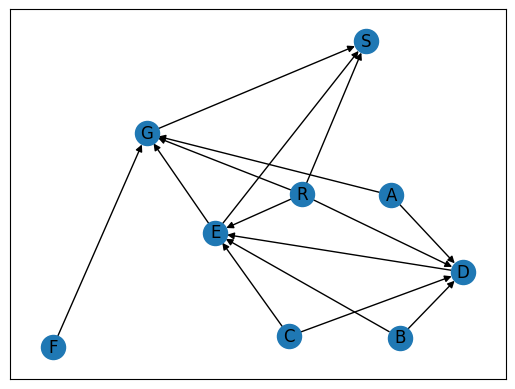

In [1]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("A", "D"), ("A", "G"), ("B", "D"), ("B", "E"), ("C", "D"), ("C", "E"), ("D", "E"), ("E", "G"), ("E", "S"), ("F", "G"), ("G", "S"), ("R", "S"), ("R", "G"), ("R", "E"), ("R", "D")])
nx.draw_networkx(graph)

## 2. Preprocessing weather data
First we preprocess the weather data for analysis:


In [35]:
import pandas as pd
import os

wdf = pd.read_csv(os.path.join("data", "MON_Datensatz.csv"))

#Creating an index column which we need to match with the ried_df
index = []
for count, i in enumerate(wdf['time']): #For each appearance of a date
    res = str(i[0:7]) #Since the seven first characters indicate the date
    res_2 = str(wdf['station'][count]) #We also need the weather-station to couple with the fields
    index.append(res+ "-" + res_2) #Therefore the combined here
wdf['indexer'] = index

#print(wdf)

## 3. Preprocessing ried data and merging with weather data
All data from the rieds come in a single csv-format, where each ried has an individual .csv for each vintage. We want to create a new dataset with all these rieds combined! 

In [ ]:
import glob
import numpy as np

rieds = ['Ehren', 'Hoch', 'Grill', 'Steint', 'Steinm', 'Heilig'] 
wetterStation = {'Ehren': 3805, 'Hoch': 3805, 'Grill': 3805, 'Steint': 3805, 'Steinm': 3811, 'Heilig': 3811} #3805: Wetterstation Krems, 3811: Wetterstation Langenlois

for r in rieds:
    joined_files = os.path.join(r ,"*.csv") #All files (vintages) of the ried
    joined_list = glob.glob(joined_files) 
    df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True) #joining all the data of the ried

    #Creating an index column
    index = []
    for i in df['C0/date']:
        res = i[0:7] #which will be the first seven chars of the date-column (4 for year, a dash and two for the month)
        index.append(res)
    df['index'] = index 

    #Downsampling the mean and the stDev
    df_1 = df.groupby(['index'])['C0/mean'].mean()
    df_2 = df.groupby(['index'])['C0/stDev'].mean()
    #Annoying re-dataframing after groupby()
    df_new = pd.merge(pd.DataFrame(df_1), pd.DataFrame(df_2), on='index')

    #Adding ried
    df_new['ried'] = np.repeat(r, len(df_new)) 
    df_new['wetterStation'] = df_new['ried'].map(wetterStation) #Using the dictionary
    df_new['id'] = df_new.index.values

    #Indexer. Since we now have the wetter-station, we can create a column that looks like the one in the weather-df
    indexer = []
    for count, i in enumerate(df_new['id']):
        res = str(i)
        res_2 = str(df_new['wetterStation'][count]) 
        indexer.append(res+ "-" + res_2)
    df_new['indexer'] = indexer

    #Merge the two
    df_tot = pd.merge(df_new, wdf, on='indexer', how="left")
    print(df_tot)

    #And saving for each ried
    outpath = os.path.join("pp", r + "_pp.csv")
    df_tot.to_csv(outpath)


Now we have preprocessed all the data and merged each rieds' data with the weather data

## 4. Checking assumptions
It is a general assumption, that values are normally distributed in a fair way, before we initiate the analysis. Therefore, we plot the values of a combined dataframe!

                      C0/date    C0/min    C0/max   C0/mean  C0/stDev  \
0    2017-03-27T00:00:00.000Z  0.214737  0.685185  0.469613  0.068089   
1    2017-04-01T00:00:00.000Z  0.243038  0.743906  0.488048  0.069823   
2    2017-05-01T00:00:00.000Z  0.287985  0.845223  0.589773  0.097122   
3    2017-05-16T00:00:00.000Z  0.065978  0.866695  0.523575  0.143687   
4    2017-06-05T00:00:00.000Z  0.238576  0.804189  0.432648  0.089957   
..                        ...       ...       ...       ...       ...   
102  2023-07-19T00:00:00.000Z  0.215990  0.840000  0.465004  0.091951   
103  2023-08-13T00:00:00.000Z  0.208973  0.873160  0.573587  0.084590   
104  2023-09-02T00:00:00.000Z  0.228202  0.873431  0.636197  0.078048   
105  2023-09-07T00:00:00.000Z  0.272219  0.865186  0.633366  0.076537   
106  2023-09-12T00:00:00.000Z  0.240561  0.894320  0.581064  0.081144   

     C0/sampleCount  C0/noDataCount  C0/median    C0/p10    C0/p90  \
0              5256            2915   0.472000  0.382

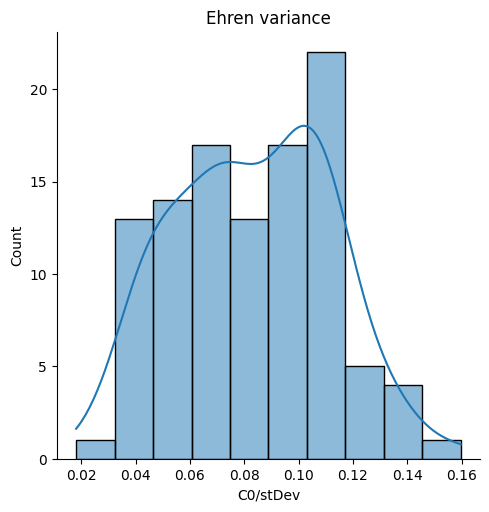

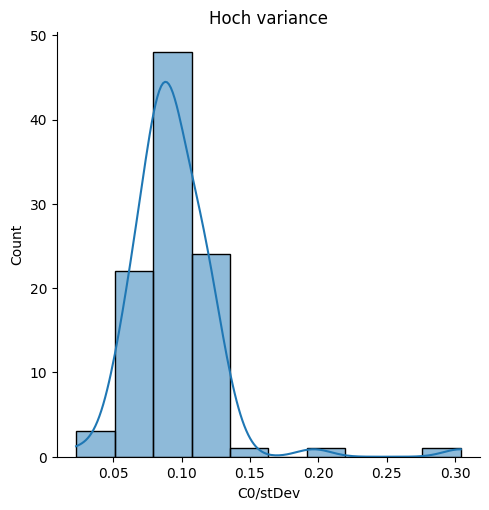

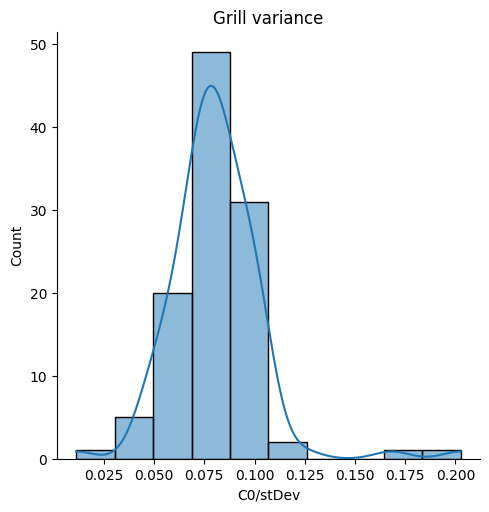

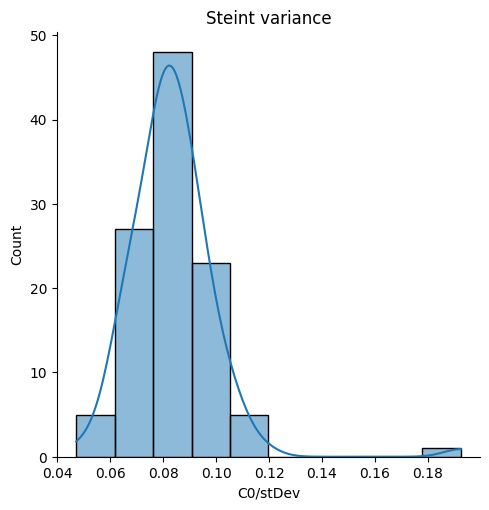

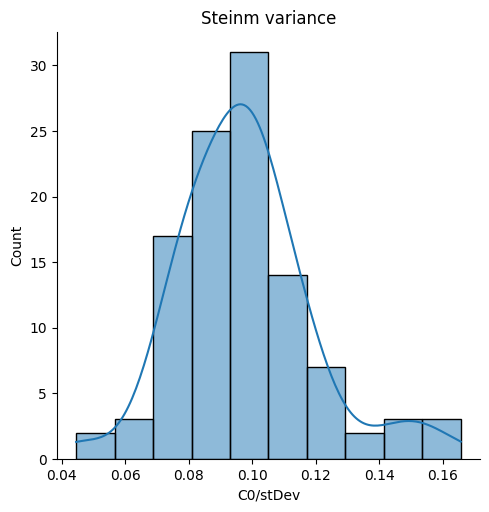

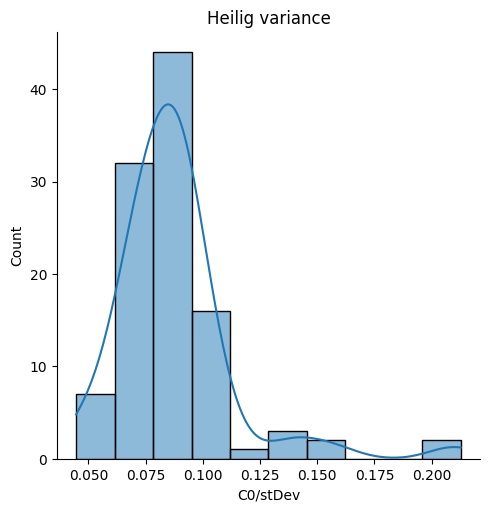

In [28]:
#Equal variance (homoschedasticity)
import glob
import seaborn as sns

rieds = ['Ehren', 'Hoch', 'Grill', 'Steint', 'Steinm', 'Heilig'] 

for r in rieds:
    joined_files = os.path.join("data", r ,"*.csv") #All files of the ried
    joined_list = glob.glob(joined_files) 
    df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True) #joining all the data of the ried


    sns.displot(df["C0/stDev"],kde=True,bins=10).set(title = r + " variance") #Checking for equal variance by plotting all stDevs


We also test the normal distribution of the preprocessed data:

     Unnamed: 0   C0/mean  C0/stDev    ried  wetterStation       id  \
0             0  0.472959  0.041233   Ehren           3805  2017-03   
1             1  0.531017  0.061505   Ehren           3805  2017-04   
2             2  0.633413  0.101563   Ehren           3805  2017-05   
3             3  0.532551  0.112162   Ehren           3805  2017-06   
4             4  0.561745  0.085928   Ehren           3805  2017-07   
..          ...       ...       ...     ...            ...      ...   
289          44  0.607484  0.091965  Steint           3805  2023-05   
290          45  0.643916  0.073788  Steint           3805  2023-06   
291          46  0.613867  0.078622  Steint           3805  2023-07   
292          47  0.679312  0.079859  Steint           3805  2023-08   
293          48  0.689874  0.091387  Steint           3805  2023-09   

          indexer                    time  station  schreg      s  sonn0  \
0    2017-03-3805  2017-03-01T00:00+00:00     3805     0.0  150.0    1.

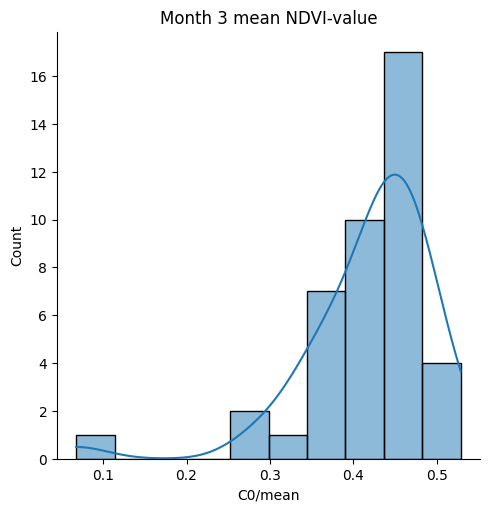

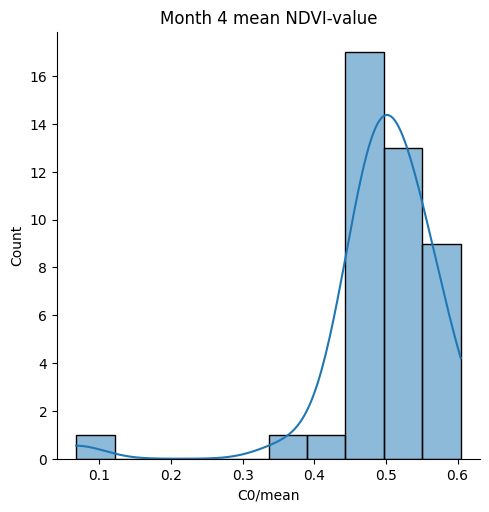

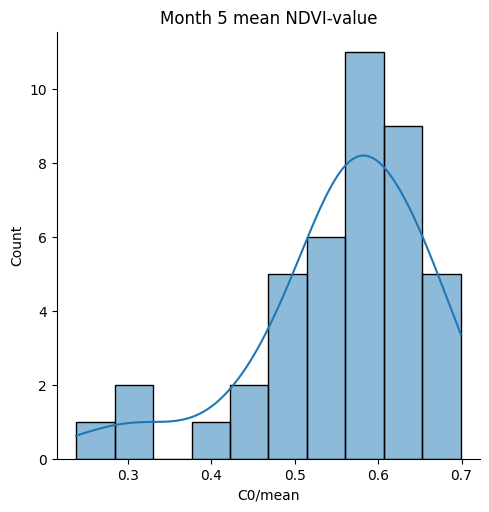

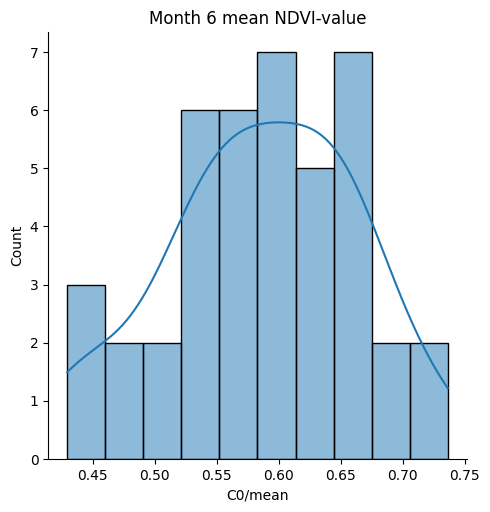

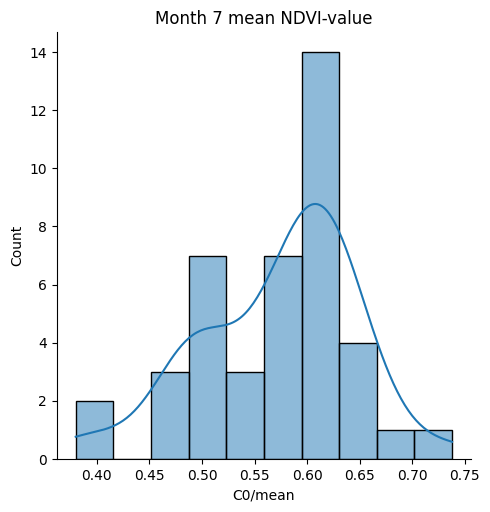

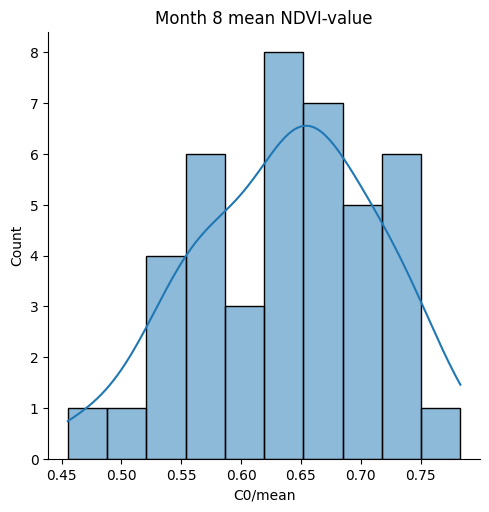

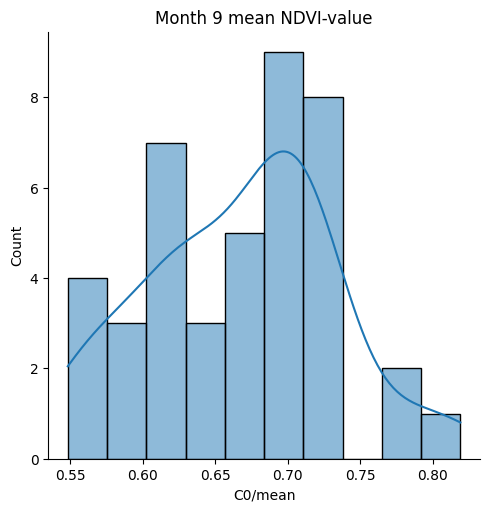

In [27]:
#Equal (normal) distribution of each month's NDVI

# Import Data
joined_files = os.path.join("data", "pp" ,"*.csv") #All files
joined_list = glob.glob(joined_files) 
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True) #joining

df['mon'] = pd.to_datetime(df['time']).dt.month
indexer = [3,4,5,6,7,8,9]

for i in indexer:
    df_fil = df.loc[df['mon'] == i]
    sns.displot(df_fil['C0/mean'], kde=True, bins=10).set(title="Month " + str(i) + " mean NDVI-value")

And it is concluded that all the assumptions somewhat hold

## 5. Assumptions. Seasonal plots for each ried to assess individuality
To investigate the trends of each ried, each ried's average value were plotted:

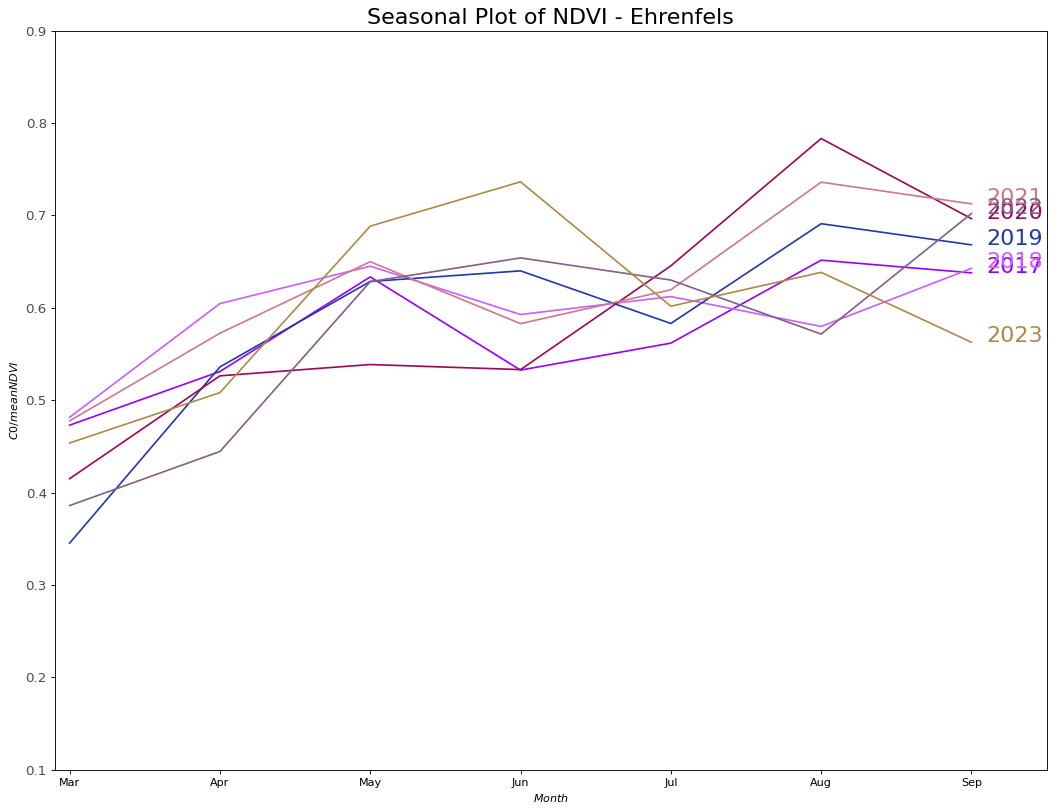

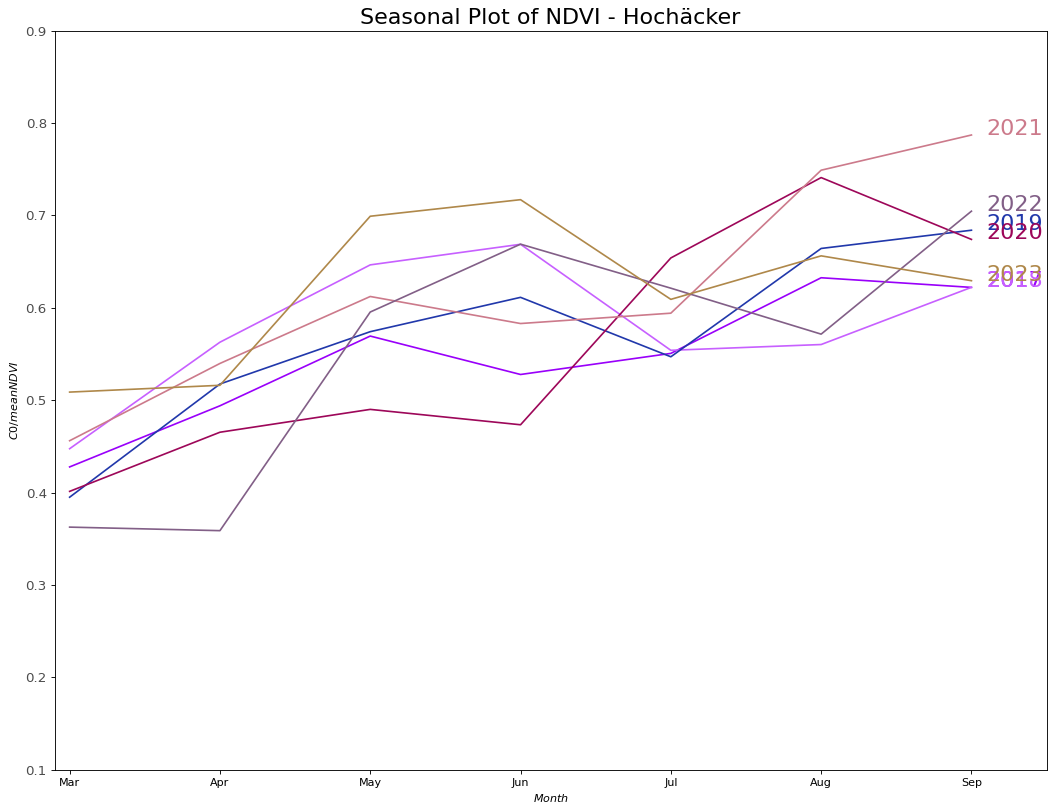

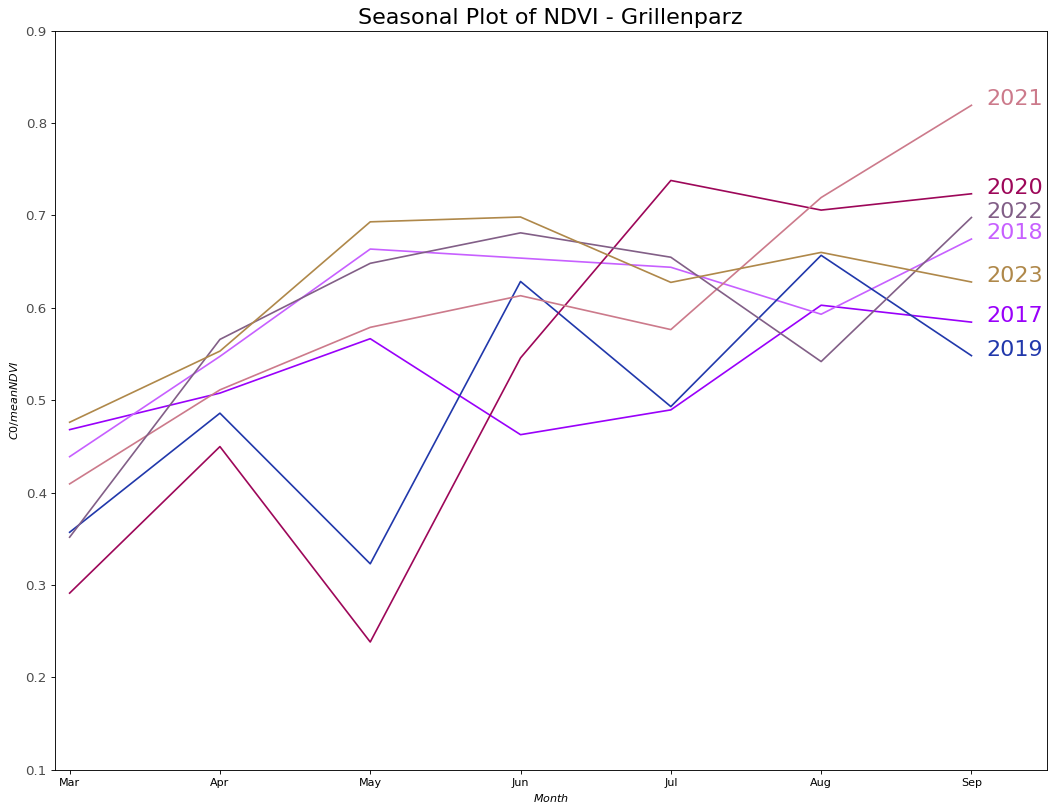

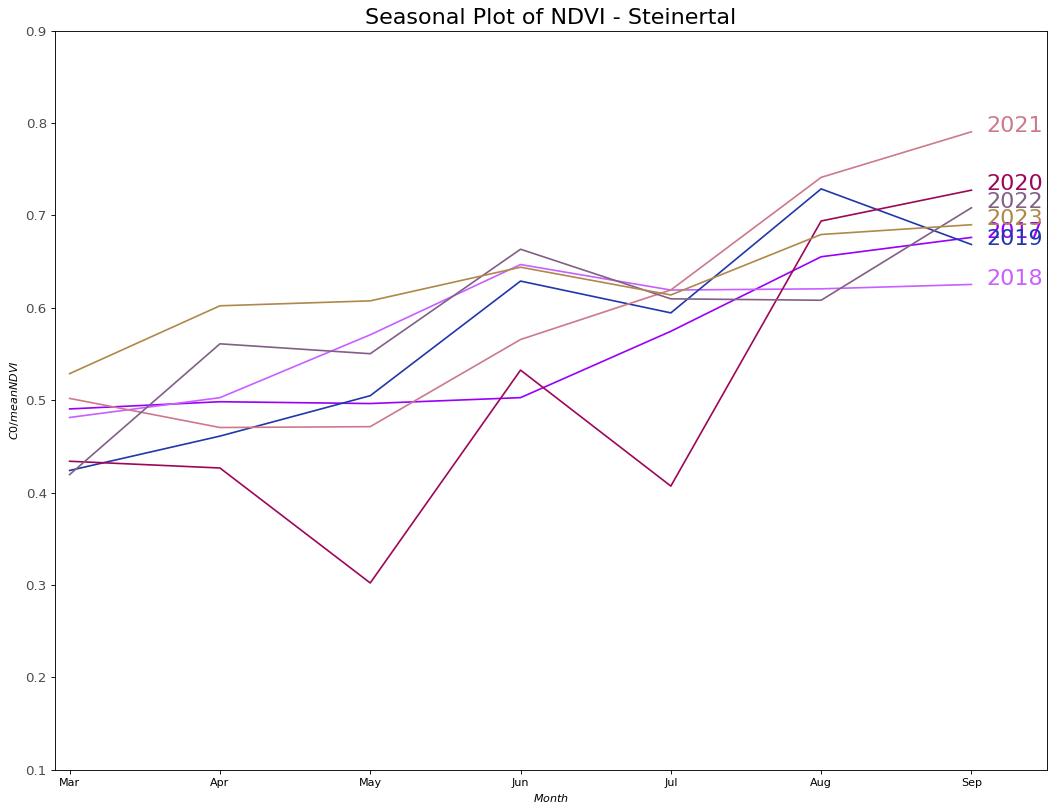

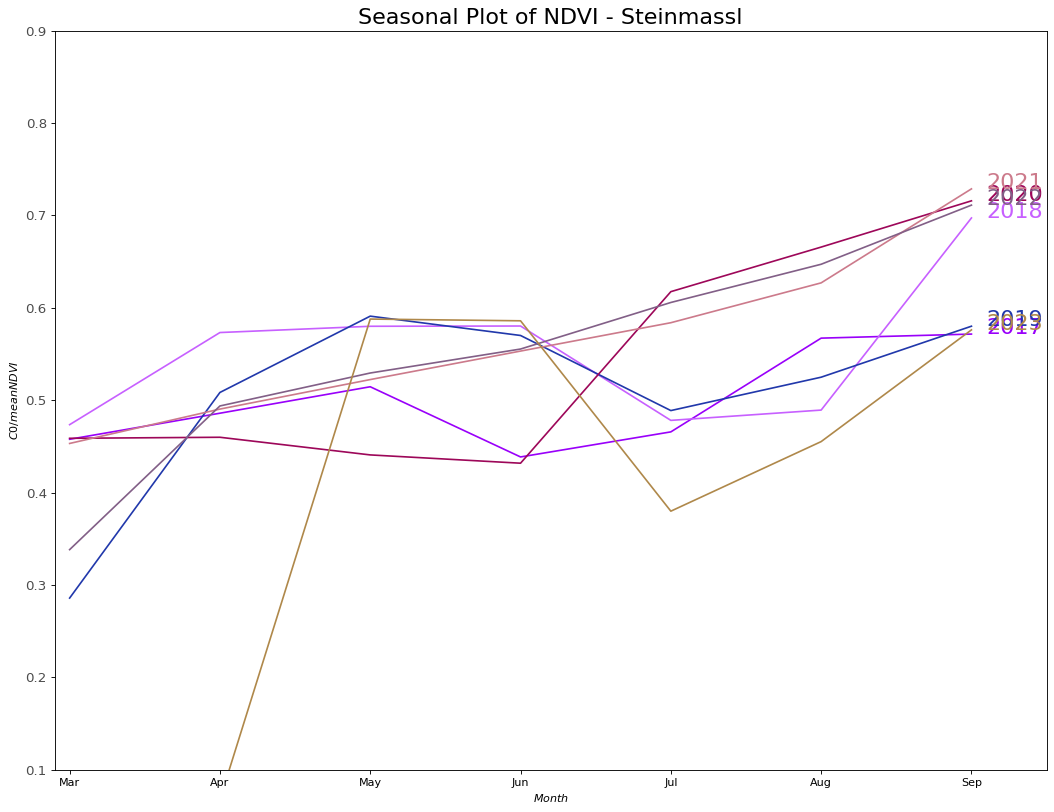

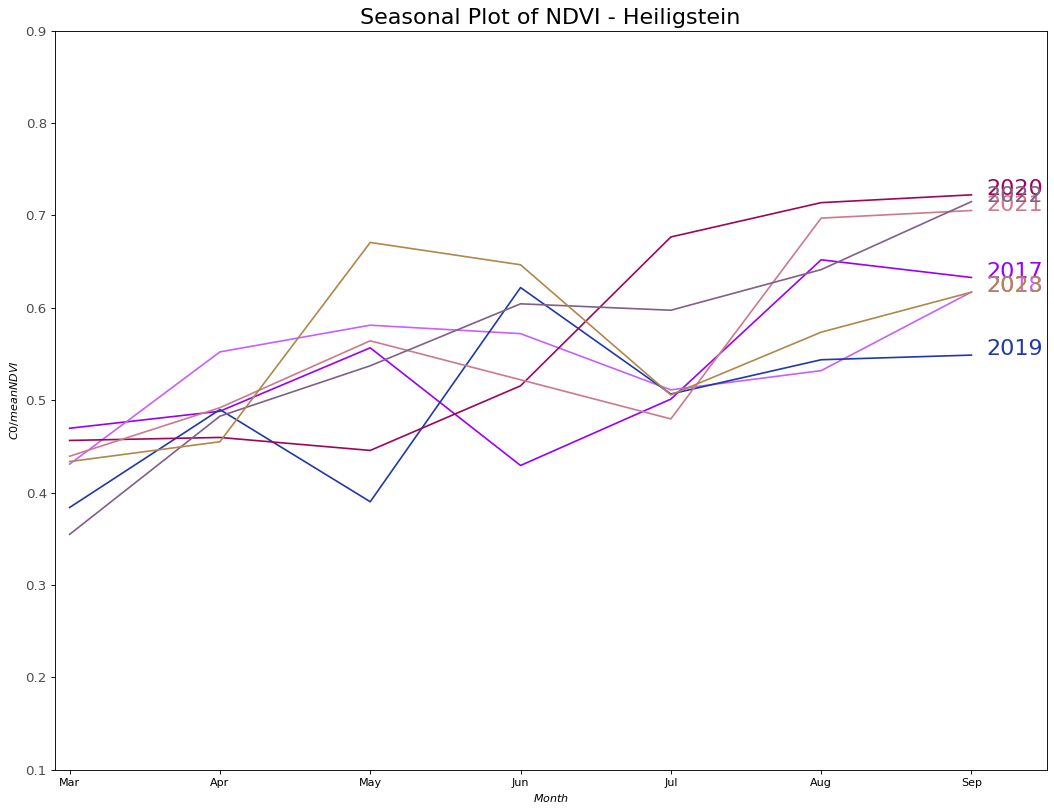

In [30]:
#Plotting mainly adapted from https://www.machinelearningplus.com/time-series/time-series-analysis-python/
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

rieds = ['Ehren', 'Hoch', 'Grill', 'Steint', 'Steinm', 'Heilig']
names = ['Ehrenfels', 'Hochäcker', 'Grillenparz', 'Steinertal', 'Steinmassl', 'Heiligstein']

for count, r in enumerate(rieds):
    # Import Data
    df = pd.read_csv(os.path.join("data", "pp", r + "_pp.csv")) 
    df.reset_index(inplace=True)
    df['date'] = pd.to_datetime(df['time']) #Create the special data-format that we use in the next block


    # Prepare data
    df['year'] = [d.year for d in df.date] #A year column
    df['month'] = [d.strftime('%b') for d in df.date] #a month colum
    years = df['year'].unique() #for indexing

#print(df)

    # Prep Colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False) #Cool command to choose colurs!

# Draw Plot. Adapted from https://www.machinelearningplus.com/time-series/time-series-analysis-python/
    plt.figure(figsize=(16,12), dpi= 80)
    for i, y in enumerate(years):
        if i >= 0:        
            plt.plot('month', 'C0/mean', data=df.loc[df.year==y, :], color=mycolors[i], label=y) #Plotting x=month and y=C0/mean
            plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'C0/mean'][-1:].values[0], y, fontsize=20, color=mycolors[i])

# Decoration
    plt.gca().set(xlim=(-0.1, 6.5), ylim=(0.1, 0.9), ylabel='$C0/mean NDVI$', xlabel='$Month$') #limits
    plt.yticks(fontsize=12, alpha=.7)
    plt.title("Seasonal Plot of NDVI - " + names[count], fontsize=20)
    #plt.savefig(r + "_Seasonal_plot.png")
    plt.show() 


## 6. Decomposing the NDVI-variable
As noted in the report, we assume the NDVI-variable to be built up of 4 components: Base level, trend, seasonality and residuals. In accordance with the report we aim to find out whether these components can be seen as additive or multiplicative. This is based on the recommendations of https://www.machinelearningplus.com/time-series/time-series-analysis-python/


                              value
date                               
2017-03-01 00:00:00+00:00  0.472959
2017-03-01 00:00:00+00:00  0.469613
2017-03-01 00:00:00+00:00  0.427755
2017-03-01 00:00:00+00:00  0.457699
2017-03-01 00:00:00+00:00  0.490527
...                             ...
2023-09-01 00:00:00+00:00  0.629294
2023-09-01 00:00:00+00:00  0.627891
2023-09-01 00:00:00+00:00  0.562691
2023-09-01 00:00:00+00:00  0.576080
2023-09-01 00:00:00+00:00  0.689874

[294 rows x 1 columns]
                              value
date                               
2017-03-01 00:00:00+00:00  0.464445
2017-04-01 00:00:00+00:00  0.500810
2017-05-01 00:00:00+00:00  0.556151
2017-06-01 00:00:00+00:00  0.482274
2017-07-01 00:00:00+00:00  0.523879
2017-08-01 00:00:00+00:00  0.626843
2017-09-01 00:00:00+00:00  0.620799
2018-03-01 00:00:00+00:00  0.458897
2018-04-01 00:00:00+00:00  0.557143
2018-05-01 00:00:00+00:00  0.614486
2018-06-01 00:00:00+00:00  0.619038
2018-07-01 00:00:00+00:00  0.569744
2018

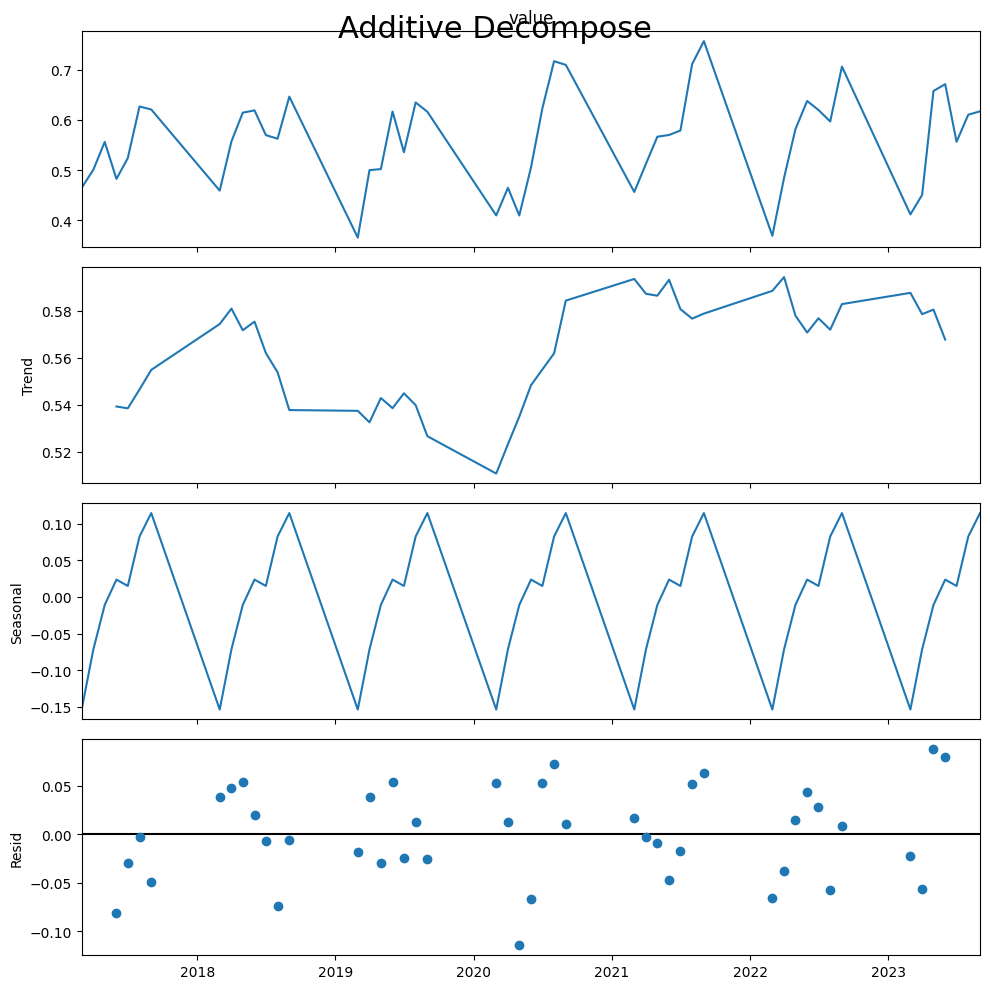

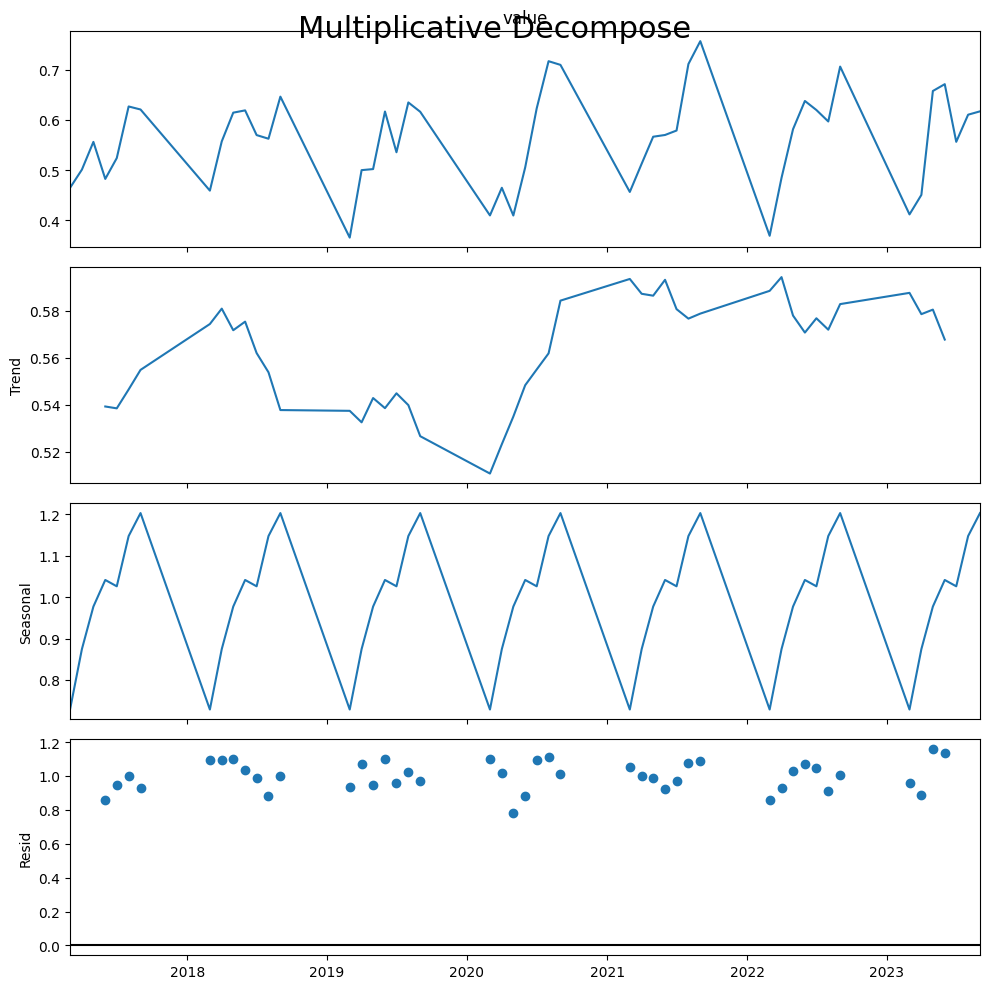

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

joined_files = os.path.join("data", "pp" ,"*.csv") #All files
joined_list = glob.glob(joined_files) 
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=False) #joining
df['date'] = pd.to_datetime(df['time']) #The datatrick from before
df = df.set_index('date')

#A little annoying side-step because I need to read the dataset in with specific values
df = df.filter(items=['date', 'C0/mean']).rename(columns= {'date':'date', 'C0/mean':'value'})
df = df.sort_index()
df.to_csv(os.path.join("all_data.csv"))

#... which is done here
df_n = pd.read_csv("all_data.csv", parse_dates=['date'], index_col='date')
df_1 = df_n.groupby(['date'])['value'].mean()
df_new = pd.DataFrame(df_1)
#print(df_n)
print(df_new)

# Additive Decomposition
result_add = seasonal_decompose(df_new['value'], model='additive', period=7)
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_new['value'], model='multiplicative', period=7)


# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
#plt.savefig("All Rieds" + "seasonalityandtrend.png")
plt.show()

In [32]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
print(df_reconstructed)

                               seas     trend     resid  actual_values
date                                                                  
2017-03-01 00:00:00+00:00 -0.154071       NaN       NaN       0.464445
2017-04-01 00:00:00+00:00 -0.071678       NaN       NaN       0.500810
2017-05-01 00:00:00+00:00 -0.010906       NaN       NaN       0.556151
2017-06-01 00:00:00+00:00  0.023813  0.539314 -0.080853       0.482274
2017-07-01 00:00:00+00:00  0.015103  0.538522 -0.029746       0.523879
2017-08-01 00:00:00+00:00  0.082819  0.546569 -0.002545       0.626843
2017-09-01 00:00:00+00:00  0.114920  0.554903 -0.049025       0.620799
2018-03-01 00:00:00+00:00 -0.154071  0.574441  0.038528       0.458897
2018-04-01 00:00:00+00:00 -0.071678  0.580993  0.047829       0.557143
2018-05-01 00:00:00+00:00 -0.010906  0.571797  0.053595       0.614486
2018-06-01 00:00:00+00:00  0.023813  0.575462  0.019763       0.619038
2018-07-01 00:00:00+00:00  0.015103  0.562071 -0.007430       0.569744
2018-0

And just to be sure. There is no stationarity in the trend! The null hypothesis means that the time series possess a unit root and is therefore non-stationary. 

In [33]:
from statsmodels.tsa.stattools import adfuller, kpss

df = pd.read_csv(os.path.join("all_data.csv"))
df_1 = df_n.groupby(['date'])['value'].mean()
df_new = pd.DataFrame(df_1)


# ADF Test
result = adfuller(df_new.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.5508955165655185
p-value: 0.5082008432706188
Critial Values:
   1%, -3.596635636000432
Critial Values:
   5%, -2.933297331821618
Critial Values:
   10%, -2.6049909750566895


Since it is impossible to reject the null-hypothesis, the series is non-stationary - meaning that there is indeed a trend and that the seasonality does not alone explain the variance!

## 7. Final boxplotting of the rieds - in summed basis


C:\Users\jeggl\AppData\Local\Temp\ipykernel_10260\935839818.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


     index  Unnamed: 0   C0/mean  C0/stDev    ried  wetterStation       id  \
0        0           0  0.472959  0.041233   Ehren           3805  2017-03   
1        1           1  0.531017  0.061505   Ehren           3805  2017-04   
2        2           2  0.633413  0.101563   Ehren           3805  2017-05   
3        3           3  0.532551  0.112162   Ehren           3805  2017-06   
4        4           4  0.561745  0.085928   Ehren           3805  2017-07   
..     ...         ...       ...       ...     ...            ...      ...   
289    289          44  0.607484  0.091965  Steint           3805  2023-05   
290    290          45  0.643916  0.073788  Steint           3805  2023-06   
291    291          46  0.613867  0.078622  Steint           3805  2023-07   
292    292          47  0.679312  0.079859  Steint           3805  2023-08   
293    293          48  0.689874  0.091387  Steint           3805  2023-09   

          indexer                    time  station  ...     t  

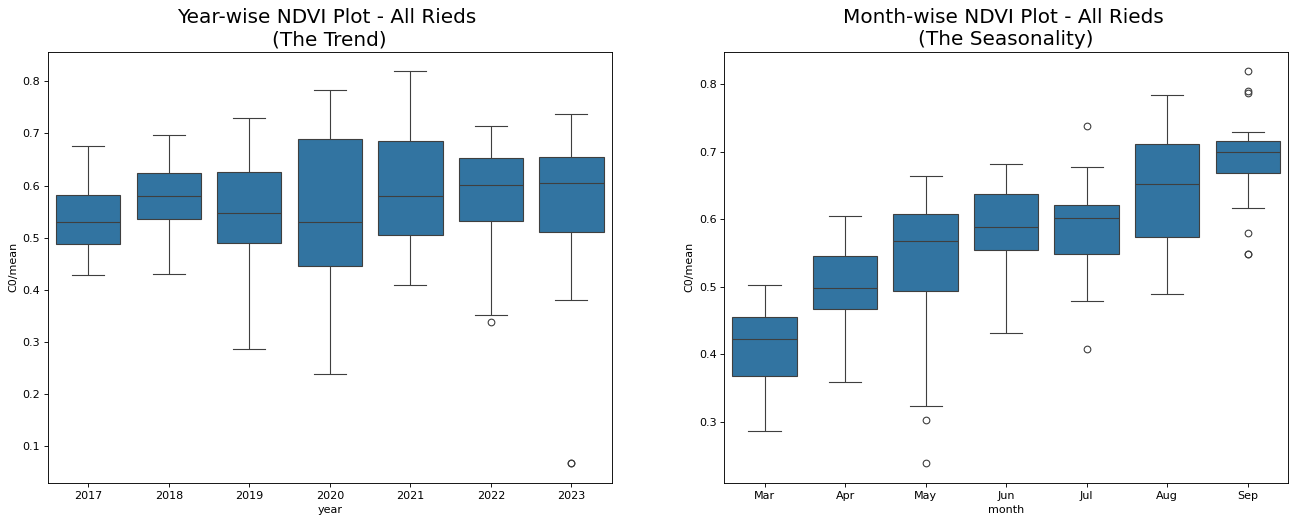

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data
joined_files = os.path.join("..", "data", "pp" ,"*.csv") #All files
joined_list = glob.glob(joined_files) 
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True) #joining
df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['time'])


# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

print(df)

#print(df)

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='C0/mean', data=df, ax=axes[0]) #NDVI year
#sns.barplot(x='year', y='rsum', data=df, ax=axes[0]) #Summed rain per year
#sns.barplot(x='year', y='s', data=df, ax=axes[0]) #Summed hours of sunshine per year
sns.boxplot(x='month', y='C0/mean', data=df.loc[~df.year.isin([2017, 2023]), :], ax=axes[1]) #NDVI month
#sns.barplot(x='month', y='rsum', data=df.loc[~df.year.isin([2017, 2023]), :]) #Avg summed rain per month
#sns.barplot(x='month', y='s', data=df.loc[~df.year.isin([2017,2023]), :]) #Avg hours of sunshine monthly

# Set Title
axes[0].set_title('Year-wise NDVI Plot - All Rieds \n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise NDVI Plot - All Rieds \n(The Seasonality)', fontsize=18)
#plt.savefig("All Rieds" + "_boxplot.png")
plt.show() 

In [2]:
print(df)

     index  Unnamed: 0   C0/mean  C0/stDev    ried  wetterStation       id  \
0        0           0  0.472959  0.041233   Ehren           3805  2017-03   
1        1           1  0.531017  0.061505   Ehren           3805  2017-04   
2        2           2  0.633413  0.101563   Ehren           3805  2017-05   
3        3           3  0.532551  0.112162   Ehren           3805  2017-06   
4        4           4  0.561745  0.085928   Ehren           3805  2017-07   
..     ...         ...       ...       ...     ...            ...      ...   
289    289          44  0.607484  0.091965  Steint           3805  2023-05   
290    290          45  0.643916  0.073788  Steint           3805  2023-06   
291    291          46  0.613867  0.078622  Steint           3805  2023-07   
292    292          47  0.679312  0.079859  Steint           3805  2023-08   
293    293          48  0.689874  0.091387  Steint           3805  2023-09   

          indexer                    time  station  ...     t  